In [1]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR, DynamicVAR
import statsmodels.api as sm
%matplotlib inline

C:\Users\Laurens\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
data = pd.read_csv('data.csv') #Three stocks (R,X_s,X_b) Without predictors

1.19656709132
1.08880018824
1.43191271231
1.1297379508
0.140826525302
0.0951966185811
0.387917446902
0.144814656555


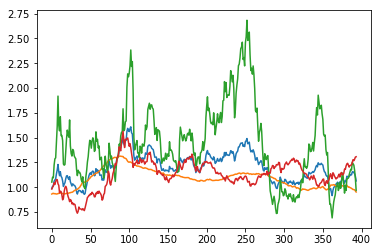

In [6]:
# Model-free benchmarks (1/N or full in the other assets)
# index 239 is the beginning of the out-of-sample analysis 754 (last)
a0 = [1/3,1/3,1/3]
a1 = [1,0,0]
a2 = [0,1,0]
a3 = [0,0,1]

r0list = []
r1list = []
r2list = []
r3list = []
for i in range(239,753-120):
    r0 = 0
    r1 = 0
    r2 = 0
    r3 = 0
    for j in range(1,60):
        s1 = data.iloc[i+j,1:4].values.reshape(1,3)
        r0 += sum(a0*s1[0])
        r1 += sum(a1*s1[0])
        r2 += sum(a2*s1[0])
        r3 += sum(a3*s1[0])
    # transform from cumulative log return to Terminal wealth (given starting wealth is normalized to 1)
    r0 = np.exp(r0)
    r1 = np.exp(r1)
    r2 = np.exp(r2)
    r3 = np.exp(r3)
    r0list.append(r0)
    r1list.append(r1)
    r2list.append(r2)
    r3list.append(r3)
    
plt.plot(r0list)
plt.plot(r1list)
plt.plot(r2list)
plt.plot(r3list)

print(np.mean(r0list))
print(np.mean(r1list))
print(np.mean(r2list))
print(np.mean(r3list))

print(np.sqrt(np.var(r0list)))
print(np.sqrt(np.var(r1list)))
print(np.sqrt(np.var(r2list)))
print(np.sqrt(np.var(r3list)))

df = pd.DataFrame({'1/N':r0list, 'full r': r1list, 'full Xs':r2list,'full Xb':r3list})
df.to_excel('Results_MF_Benchmark.xlsx', sheet_name='sheet1')
    

In [16]:
print(int(n-periods-1))
print(np.exp(sum(optimalweights*mdata[i+1:i+currentK+1]['xs'] + (1-optimalweights)*mdata[i+1:i+currentK+1]['xb'])))

690
1.51482612743


In [3]:
# Model benchmark (classical portfolio management) NEEDS OPTIMIZATION ESPECIALLY FOR LARGER RUNS, sim and slice)
# expanding window + investment horizon = 5 years (K = 60)

# parsing data
dates = data['Date']
mdata = data[['r','xs','xb']]
mdata.index = pd.DatetimeIndex(dates)
n = data.size/4-4
periods = 60
simul = 400
beginperiod = 281
gamma = 10 #5 #2 
TW = []
MWeights = []
Index = []
#Turnover = []
#RU = []

for i in range(beginperiod,int(n-periods-1)): #   n-periods-1): (possiblity to serialize) (Check 241 )
    # initialization
    optimalweights = np.zeros(periods-1)
    currentK = 0
    
    while currentK < periods-1:
        K = periods - currentK
        
        ## Simulate from the estimate VAR(1) model
        model = VAR(mdata[0:i+currentK]) # take a smaller range to improve speed (like i - 200)
        results = model.fit(1)   # fit a VAR(1) model on the data based on only the returns (no predictability)
        A = results.coefs
        sim = [[[0 for x in range(3)] for k in range(0,K)] for j in range(0,simul)]
        for j in range(0,simul):
            eps = np.sqrt(np.var(results.resid)).values.reshape(1,3)
            x0 = np.random.normal(0,eps[0][0],K)
            x1 = np.random.normal(0,eps[0][1],K)
            x2 = np.random.normal(0,eps[0][2],K)

            for k in range(0,K):
                if k == 0:
                    Ahat = mdata[i:i+1+currentK].values.dot(A[0].transpose())
                    Ahat = Ahat[0]
                else:
                    Ahat = np.array(np.array(sim[j][k-1]).dot(A[0].transpose()))
                sim[j][k][0] = Ahat[0] + x0[k]
                sim[j][k][1] = Ahat[1] + x1[k]
                sim[j][k][2] = Ahat[2] + x2[k]
                
        ## Calculate the optimal weights 
        W = np.linspace(0,1,10)
        Ufut = np.ones(simul)
        OptU = np.ones(simul)*-999
        OptW = np.zeros(simul)
        U = np.zeros(simul)

        for k in range(1,K+1):
            if k < K:
                for w in W:
                    for j in range(0,simul):
                        U[j] = (1/(1-gamma))*(pow((w*np.exp(sim[j][K-k][1]) + (1-w)*np.exp(sim[j][K-k][2])),(1-gamma))*Ufut[j])
                        # Eventually K-k-1 because now i calculate fut Utility of time period T+K+1
                    slice = []
                    for x in range(0,simul):
                        slice.append(sim[x][K-k][1:3])
                    slice = sm.add_constant(slice)
                    olsmodel = sm.OLS(U, slice)
                    CU = olsmodel.fit()
#                     print(CU.params)
                    CU = np.sum(slice * CU.params, axis=1)
                    for j in range(0, simul):
                        if CU[j] > OptU[j]:
                            OptU[j] = CU[j]
                            OptW[j] = w
                slicexs = []
                slicexb = []
                for x in range(0,simul):
                    slicexs.append(sim[x][K-k][1])
                    slicexb.append(sim[x][K-k][2])
                Ufut = (pow(OptW*np.exp(slicexs) + (1-OptW)*np.exp(slicexb),(1-gamma))*Ufut)
#                 print(OptW*np.exp(slicexs))
                OptU = np.ones(simul)*-999
                OptW = np.zeros(simul)
            else:
                for w in W:
                    for j in range(0,simul):
                        U[j] = (1/(1-gamma))*((pow(w*np.exp(sim[j][K-k][1]) + (1-w)*np.exp(sim[j][K-k][2]),(1-gamma)))*Ufut[j])
                    olsmodel = sm.OLS(U, np.ones(simul))
                    CU = olsmodel.fit()
                    CU = np.ones(simul) * CU.params
                    for j in range(0, simul):
                        if CU[j] > OptU[j]:
                            OptU[j] = CU[j]
                            OptW[j] = w

        optimalweights[currentK] = OptW[1] 
        currentK += 1
    print(i)
    
    # Calculate the Terminal Wealth from the given optimalweights  (Check whether indexes are right)
    TW.append(np.exp(sum(optimalweights*mdata[i+1:i+currentK+1]['xs'] + (1-optimalweights)*mdata[i+1:i+currentK+1]['xb'])))
    MWeights.append(np.mean(optimalweights))
    Index.append(i)
    #Turnover.append()
    #RU.append()
    
    print('Writing away results')
    df = pd.DataFrame({'index date':Index,'TW':TW, 'Mean Weights Xs':MWeights})
#     df = pd.DataFrame({'index date':Index,'TW':TW, 'Mean Weights Xs':MWeights,'Turnover':Turnover, 'Realized Utility':RU})
    df.to_excel('ResultsExp_CP_g10_gamma10.xlsx', sheet_name='sheet1', index=False)

241
Writing away results
242
Writing away results
243
Writing away results
244
Writing away results
245
Writing away results
246
Writing away results
247
Writing away results
248
Writing away results
249
Writing away results
250
Writing away results
251
Writing away results
252
Writing away results
253
Writing away results
254
Writing away results
255
Writing away results
256
Writing away results
257
Writing away results
258
Writing away results
259
Writing away results
260
Writing away results
261
Writing away results
262
Writing away results
263
Writing away results
264
Writing away results
265
Writing away results
266
Writing away results
267
Writing away results
268
Writing away results
269
Writing away results
270
Writing away results
271
Writing away results
272
Writing away results
273
Writing away results
274
Writing away results
275
Writing away results
276
Writing away results
277
Writing away results
278
Writing away results
279
Writing away results
280
Writing away results


KeyboardInterrupt: 

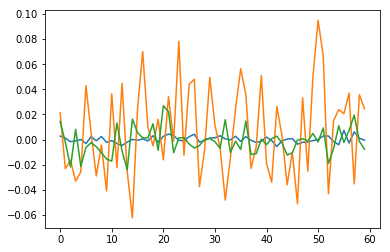

In [34]:
K = 60

sim = [[[0 for x in range(3)] for k in range(0,K)] for j in range(0,simul)]
eps = np.sqrt(np.var(results.resid)).values.reshape(1,3)
x0 = np.random.normal(0,eps[0][0],K)
x1 = np.random.normal(0,eps[0][1],K)
x2 = np.random.normal(0,eps[0][2],K)

for k in range(0,K):
    if k == 0:
        Ahat = mdata[i:i+1].values.dot(A[0].transpose())
        Ahat = Ahat[0]
    else:
        Ahat = np.array(np.array(sim[j][k-1]).dot(A[0].transpose()))
    sim[j][k][0] = Ahat[0] + x0[k]
    sim[j][k][1] = Ahat[1] + x1[k]
    sim[j][k][2] = Ahat[2] + x2[k]
    
plt.plot(sim[0])